# Python - Example of loading from *.txt ADCP


**Aim:** To load and plot ADCP data from a `*.txt` file (`ascii_template_20230511_002_ASC_Analyse.TXT`), from the Seepraktikum in 2023.

**Data:** Download the data files from last year's data repository.

**Directions:** Create an `*.ipynb` and 2 figures: the sections of velocity.

**Uses:** [read_ascii_data.py](read_ascii_data.py) from Yves Sorge.
<hr>

In [37]:
# Your code here
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import scipy.io as sio
from datetime import date
from read_ascii_data import *


# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import palettable.colorbrewer.sequential as cbseq

from palettable.colorbrewer.sequential import Blues_8
from palettable.cartocolors.sequential import Sunset_7_r
from palettable.cartocolors.sequential import BluYl_7


<xarray.Dataset>
Dimensions:    (time: 4002, depth: 116)
Coordinates:
  * time       (time) datetime64[ns] 2024-05-26T13:23:54 ... 2024-05-26T15:02:02
  * depth      (depth) float64 0.0 2.55 3.05 3.55 ... 58.05 58.55 59.05 59.55
Data variables:
    direction  (time, depth) float64 279.5 288.8 267.2 272.0 ... nan nan nan nan
    magnitude  (time, depth) float64 0.327 0.23 0.286 0.529 ... nan nan nan nan
    longitude  (time) float64 8.567 8.568 8.568 8.568 ... 8.859 8.859 8.859
    latitude   (time) float64 54.11 54.11 54.11 54.11 ... 54.12 54.12 54.12


/Users/eddifying/micromamba/envs/seaocn_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/eddifying/micromamba/envs/seaocn_env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


(array([[218., 723., 917., ...,  56.,  15.,   4.],
        [338., 854., 813., ...,   5.,   0.,   0.],
        [399., 954., 797., ...,   2.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.    , 0.1599, 0.3198, 0.4797, 0.6396, 0.7995, 0.9594, 1.1193,
        1.2792, 1.4391, 1.599 ]),
 <a list of 116 BarContainer objects>)

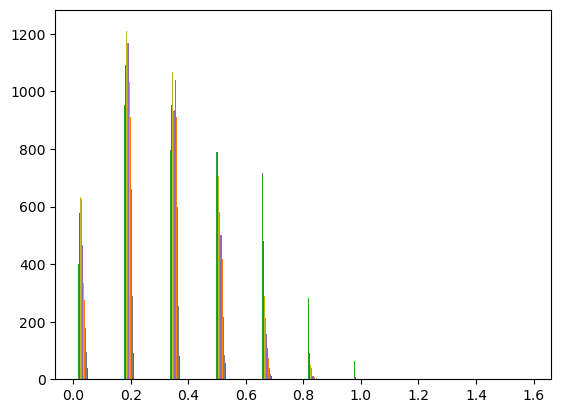

In [54]:
# File paths
file_path = '/Users/eddifying/Dropbox/data/SeePrakt-data/2023-seepraktikum/adcp-data/ascii/'
filename = 'ascii_template_20230511_002_ASC_Analyse.TXT'
file_path = '/Users/eddifying/Dropbox/Public/uhh-teaching/Seepraktikum_2024/'
filename='uhh_sp_2024_003_ASC.TXT'
# Open the *.txt file in excel
# Select one row and copy this
# Paste this row into a new excel spreadsheet
# Create a row above to number the columns
# Figure out where the date values start and end (starts with the two digit year, one digit month, one-two digit day, then hour, minute second
# Figure out where the depth values start and end.  It'll start with 0, have a blank until about 2.5 m, then increment every 0.5m until around 60m
# Direction will be as long as depth (and range from 0-360), but only the first few values will be valid (thereafter -32768)
# Magnitude is similar
fname = file_path + filename
# Define index ranges and constants
INDEX_RANGES = {
    'date'      : (2, 8),
    'depth'     : (11, 128),
    'lat'       : 130,
    'lon'       : 129,
    'dir0'      : (131, 247),
 #   'magnitude'    : (248, 364),
#    'magnitude'     : (365, 481),
    'direction' : (482, 598),
    'magnitude' : (599, 715),
 #   'magnitude'    : (716, 832),
 #   'magnitude'    : (833, 949)
}

# Define NaN value
NAN_VALUE = -32768

ds = read_adcp_ascii_file( fname, 'UHH Sea Practical 2024', 'stnx', INDEX_RANGES, NAN_VALUE)

ds=ds.drop_vars('cruise')
ds=ds.drop_vars('station')

print(ds)
plt.hist(ds.magnitude)

## 1. Take a look at the data


In [55]:
print('Velocity magnitude vector is '+str(ds.magnitude.shape))
print('Time vector is '+str(ds.time.shape))
print('Depth vector is '+str(ds.depth.shape))

interval_secs = np.diff(ds.time).mean()/ np.timedelta64(1, 's')
print('Time interval in seconds is '+str(interval_secs))

Velocity magnitude vector is (4002, 116)
Time vector is (4002,)
Depth vector is (116,)
Time interval in seconds is 1.471632091


## 2. First start with a 5-minute average

The first method here creates a rolling average (also known as moving average or boxcar filter) for a 5-minute window (a typical window for ADCP averaging).  However, the `rolling` method results in a dataset which has the same dimensions as the original.

The second method resamples the data using an average (so also like a rolling average) over 5-minutes.  Now the dataset has become much compressed.

Note that in both cases, there is some time-shifting that is occurring.  In order to have data centered on the middle of the 5-minute average, we have had to do some additional calculations.

In the case of the rolling average, we've passed the option `center=True`

In the case of the resample, we've re-assigned the coordinates using `np.timedelta(minutes=2.5)`

```{seealso}
For those of you in Seagoing Oceanography, see also [seaocn Ex2b](https://ifmeo-hamburg.github.io/seaocn/exercise/exercise-filter.html)
```

In [56]:
# Find the window-length
NN = np.ceil(60*5 / interval_secs)
print(NN)

print('Using a filter window length of NN='+str(NN)+' to make 5-minute averages')

204.0
Using a filter window length of NN=204.0 to make 5-minute averages


In [57]:
# Calculate a rolling average
ds5min = ds.rolling(time=int(NN), center=True).mean()

# Resample onto a 5-minute average
ds5min_resample = ds.resample(time="5Min").mean(dim='time')
ds5min_resample = ds5min_resample.assign_coords({"time": ds5min_resample.time + pd.Timedelta(minutes=2.5)})

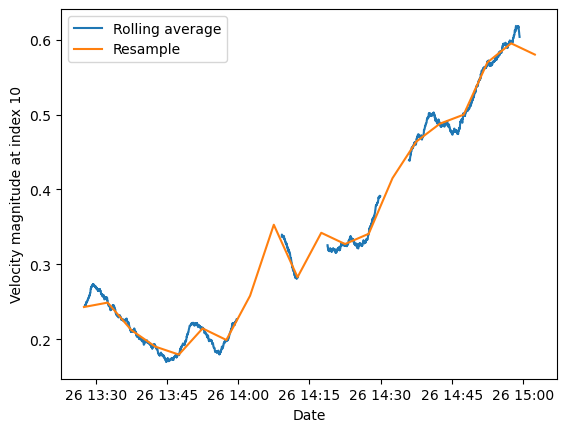

In [58]:
# Plot the outcome
fig, ax = plt.subplots()

line1, = ax.plot(ds5min.time,ds5min.magnitude[:,10])
line1.set_label('Rolling average')
line2, = ax.plot(ds5min_resample.time,ds5min_resample.magnitude[:,10])
line2.set_label('Resample')
plt.xlabel('Date')
plt.ylabel('Velocity magnitude at index 10')

plt.legend()

## 3. Now figure out what's where

In [59]:
# We've verified that the resample does what we want it to
# Now use this smaller data file for later plots
ds2 = ds5min_resample


### Make a map

Text(0, 0.5, 'Latitude')

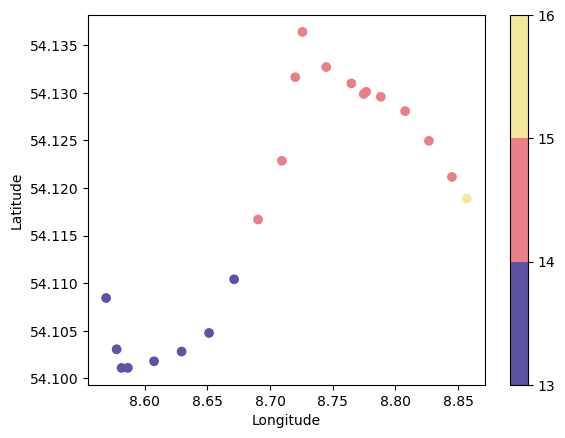

In [60]:
cmap = plt.cm.jet  # define the colormap
cmap = Sunset_7_r.mpl_colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)                               

# Hour start
tmin = mdates.date2num(ds2.time).min()
tmin = tmin-np.floor(tmin)
hourstart = np.floor(tmin*24)
# Hour end
tmax = mdates.date2num(ds2.time).max()
tmax = tmax-np.floor(tmax)
hourend = np.ceil(tmax*24)
numhours = int(hourend-hourstart+1)

hours = 24*(mdates.date2num(ds2.time)-np.floor(mdates.date2num(ds2.time).min()))

# define the bins and normalize
bounds = np.linspace(hourstart,hourend,numhours)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Make a figure showing the location (lat/lon) and the hour when the ship was there (colour)
plt.scatter(ds2.longitude,ds2.latitude,c=hours,cmap=cmap,norm=norm)
cb=plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Make a section (or in this case, time depth plot) of velocity

In [61]:
print(ds2.depth.shape)
print(ds2.time.shape)
print(ds2.magnitude.shape)

(116,)
(21,)
(21, 116)


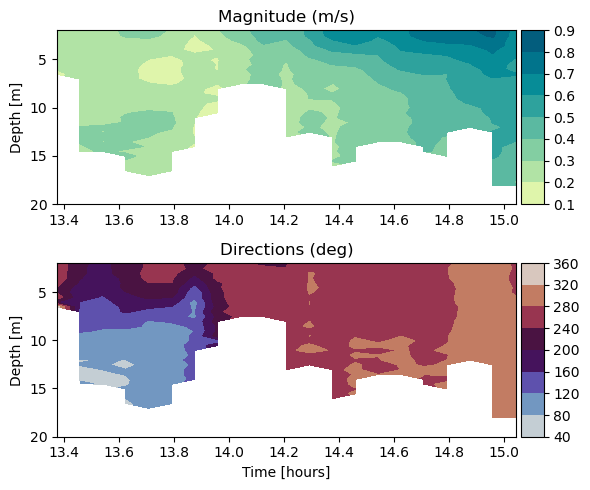

In [62]:
# Plot the magnitude against time (x) and depth (y)
fig = plt.figure(figsize=(6,5))

# Velocity magnitude
cmap = BluYl_7.mpl_colormap

# Create the upper panel with velo magnitude
ax1 = fig.add_subplot(211)
cf1 = ax1.contourf(hours,ds2.depth,ds2.magnitude.T, cmap=cmap)

# Set some annotations
ax1.set_ylim((2,20))
ax1.invert_yaxis()
ax1.set_ylabel('Depth [m]')
ax1.set_title('Magnitude (m/s)')

# Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cf1, cax=cax, orientation='vertical')


# Create the lower panel with directions
cmap = plt.cm.twilight
ax2 = fig.add_subplot(212)
cf2 = ax2.contourf(hours, ds2.depth, ds2.direction.T, cmap=cmap);
ax2.set_title('Directions (deg)')

# Add the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cf2, cax=cax, orientation='vertical');

# Set annotations
ax2.set_xlabel('Time [hours]')
ax2.set_ylim((2,20))
ax2.invert_yaxis()
ax2.set_ylabel('Depth [m]')

# Fix the spacing
fig.tight_layout()

fig.savefig('figures/adcp_section.png')

## 4. Where are velocities fast and slow?

Make a quiver plot of arrow vectors to see the u and v velocities.

In [63]:
# Test the transformation
#
# Note that for directions / heading, the definitions can vary.  
# You should always truth-check any transformations between eastward/northward and direction/magnitude
# This cell gives one idea for how to test the transformation.

u_range = [0,1,-1]
v_range = [1,0,-1]

for east_velocity in u_range:
    for north_velocity in v_range:

        # Calculate the magnitude
        magnitude = np.sqrt(east_velocity**2 + north_velocity**2)
        
        # Calculate the direction in radians
        direction_radians = np.arctan2(north_velocity, east_velocity)
        
        # Convert direction to degrees
        direction_degrees = np.degrees(direction_radians)
        
        # Ensure directions are in the range [0, 360)
        direction_degrees = (direction_degrees + 360) % 360
        

        # Check undoing transformation
        u_vel = magnitude*np.cos(direction_degrees*np.pi/180)
        v_vel = magnitude*np.sin(direction_degrees*np.pi/180)

        u_vel = np.round(u_vel)
        v_vel = np.round(v_vel)
        
        print('For u=' + str(east_velocity) + 'm/s and v=' + str(north_velocity) + 'm/s, the direction is ' + str(direction_degrees),' ::: Check (u,v)=('+str(u_vel)+','+str(v_vel),')')

print('---- For the example given here ---')
print('Defined this way, the directions are 0 points east, and degrees increment in the counter-clockwise direction')

For u=0m/s and v=1m/s, the direction is 90.0  ::: Check (u,v)=(0.0,1.0 )
For u=0m/s and v=0m/s, the direction is 0.0  ::: Check (u,v)=(0.0,0.0 )
For u=0m/s and v=-1m/s, the direction is 270.0  ::: Check (u,v)=(-0.0,-1.0 )
For u=1m/s and v=1m/s, the direction is 45.0  ::: Check (u,v)=(1.0,1.0 )
For u=1m/s and v=0m/s, the direction is 0.0  ::: Check (u,v)=(1.0,0.0 )
For u=1m/s and v=-1m/s, the direction is 315.0  ::: Check (u,v)=(1.0,-1.0 )
For u=-1m/s and v=1m/s, the direction is 135.0  ::: Check (u,v)=(-1.0,1.0 )
For u=-1m/s and v=0m/s, the direction is 180.0  ::: Check (u,v)=(-1.0,0.0 )
For u=-1m/s and v=-1m/s, the direction is 225.0  ::: Check (u,v)=(-1.0,-1.0 )
---- For the example given here ---
Defined this way, the directions are 0 points east, and degrees increment in the counter-clockwise direction


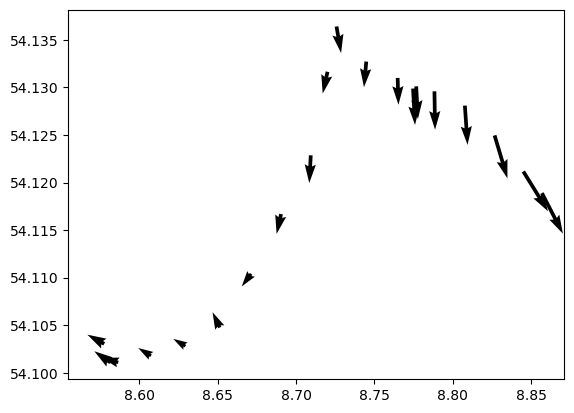

In [64]:
# Make a quiver plot
#https://stackoverflow.com/questions/19576495/color-matplotlib-quiver-field-according-to-magnitude-and-direction

u_velo = ds2.magnitude*np.cos(ds2.direction*np.pi/180)
v_velo = ds2.magnitude*np.sin(ds2.direction*np.pi/180)
#for ii in range(20,30):
for ii in range(10,11):
    x_dir1 = u_velo[:,ii]
    y_dir1 = v_velo[:,ii]
    plt.quiver(ds2.longitude, ds2.latitude, x_dir1, y_dir1)


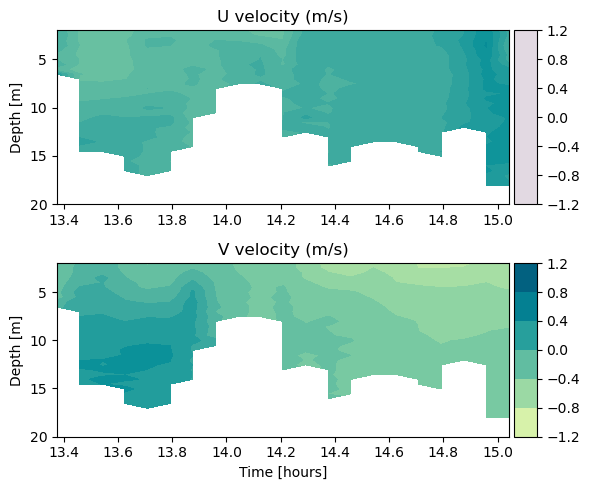

In [65]:
from matplotlib.cm import ScalarMappable

# Set some color axis limits, based on the data
vmin = -1.2
vmax = 1.2
levels=6
level_boundaries = np.linspace(vmin, vmax, levels + 1)

# Choose a colormap
cmap = BluYl_7.mpl_colormap

# Create the figure
fig = plt.figure(figsize=(6,5))

# Upper panel for U-velocity
ax1 = fig.add_subplot(211)

# Contour the data
cf1 = ax1.contourf(hours,ds2.depth,u_velo.T,cmap=cmap,
                  vmin=vmin, vmax=vmax)

# Set some annotations
ax1.set_ylim((2,20))
ax1.invert_yaxis()
ax1.set_ylabel('Depth [m]')
ax1.set_title('U velocity (m/s)')

# Add the colorbar 
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)

# Specify color limits
fig.colorbar(ScalarMappable(norm=cf2.norm, cmap=cf2.cmap),
                  cax=cax,
                  orientation='vertical',
                  boundaries=level_boundaries,
                  values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
                 )

#
# Lower panel for V-velocity
ax2 = fig.add_subplot(212)

# Contour the data
cf2 = ax2.contourf(hours,ds2.depth,v_velo.T,
                   cmap=cmap,
                   vmin=vmin, vmax=vmax
                  )

# Set some annotations
ax2.set_title('V velocity (m/s)')
ax2.set_xlabel('Time [hours]')
ax2.set_ylim((2,20))
ax2.invert_yaxis()
ax2.set_ylabel('Depth [m]')

# Add the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)

# Specify color limits
cb = fig.colorbar(ScalarMappable(norm=cf2.norm, cmap=cf2.cmap),
                  cax=cax,
                  orientation='vertical',
                  boundaries=level_boundaries,
                  values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
                 )

# Fix the spacing between subplots
fig.tight_layout()

fig.savefig('figures/adcp_UVsxn.png')